In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import numpy as np
import matplotlib.pyplot as plt
import requests
from collections import Counter
import torch.nn.functional as F
import math

In [2]:
shakespeare_url = 'https://www.gutenberg.org/files/100/100-0.txt'
war_and_peace_url = 'https://www.gutenberg.org/files/2600/2600-0.txt'
moby_dick_url = "https://www.gutenberg.org/ebooks/2701.txt.utf-8"

def load_text(url):
    response = requests.get(url)
    response.encoding = 'utf-8'
    return response.text

shakespeare_text = load_text(shakespeare_url)
war_and_peace_text = load_text(war_and_peace_url)
moby_dick_test = load_text(moby_dick_url)

combined_text = shakespeare_text + war_and_peace_text + moby_dick_test

all_chars = sorted(set(combined_text))
vocab_size = len(all_chars)

char_to_int = {char: i for i, char in enumerate(all_chars)}
int_to_char = {i: char for i, char in enumerate(all_chars)}

print(f"Total unique characters (vocabulary size): {vocab_size}")

test_sequence = combined_text[:32]
print(f"Original sequence: {test_sequence}")

Total unique characters (vocabulary size): 130
Original sequence: *** START OF THE PROJECT GUTENBE


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=ninp, nhead=nhead, dim_feedforward=nhid, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        self.input_emb = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.input_emb.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, mask=None):
        src = self.input_emb(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.encoder(src, mask=mask)
        output = self.decoder(output)
        return output

In [33]:
ntokens = vocab_size
ninp = 128
nhead = 8
nhid = 256
nlayers = 2
dropout = 0.2
context_length = 128

model = TransformerModel(ntokens, ninp, nhead, nhid, nlayers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def get_batch(text, batch_size, seq_len):
    x, y = [], []
    for _ in range(batch_size):
        start_idx = np.random.randint(0, len(text) - seq_len - 1)
        x.append([char_to_int[char] for char in text[start_idx:start_idx + seq_len]])
        y.append([char_to_int[char] for char in text[start_idx + 1:start_idx + seq_len + 1]])
    x = torch.tensor(x, dtype=torch.long).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)
    return x, y

train_losses, val_losses = [], []
train_errors, val_errors = [], []

num_epochs = 30
batch_size = 32
num_batches = 3000
update_interval = 1000
model.train()

for epoch in range(num_epochs):
    for i in range(num_batches):
        model.train()
        optimizer.zero_grad()
        x, y = get_batch(combined_text, batch_size, context_length)
        mask = model._generate_square_subsequent_mask(context_length).to(device)
        output = model(x, mask)

        loss = criterion(output.view(-1, vocab_size), y.view(-1))

        _, predictions = torch.max(output, dim=2)
        train_error = (predictions != y).float().mean().item()
        train_errors.append(train_error)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        train_losses.append(loss.item())

        if (i + 1) % update_interval == 0:
            model.eval()
            val_loss = 0
            val_error = 0
            with torch.no_grad():
                for j in range(int(.25 * num_batches)):
                    val_x, val_y = get_batch(combined_text, batch_size, context_length)
                    val_output = model(val_x, mask)
                    val_loss += criterion(val_output.view(-1, vocab_size), val_y.view(-1)).item()

                    _, val_predictions = torch.max(val_output, dim=2)
                    val_error += (val_predictions != val_y).float().mean().item()

            val_losses.append(val_loss / int(.25 * num_batches))
            val_errors.append(val_error / int(.25 * num_batches))
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{num_batches}], '
                  f'Train Loss: {loss.item():.4f}, Train Error: {train_error:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Error: {val_error:.4f}')
    #     break
    # break

Epoch [1/30], Batch [1000/3000], Train Loss: 2.4949, Train Error: 0.6978, Val Loss: 1839.6039, Val Error: 528.2385
Epoch [1/30], Batch [2000/3000], Train Loss: 2.4266, Train Error: 0.6982, Val Loss: 1760.7852, Val Error: 508.9785
Epoch [1/30], Batch [3000/3000], Train Loss: 2.3988, Train Error: 0.6924, Val Loss: 1688.3936, Val Error: 490.5850
Epoch [2/30], Batch [1000/3000], Train Loss: 2.2762, Train Error: 0.6584, Val Loss: 1628.1781, Val Error: 476.8550
Epoch [2/30], Batch [2000/3000], Train Loss: 2.2224, Train Error: 0.6438, Val Loss: 1586.9172, Val Error: 467.0293
Epoch [2/30], Batch [3000/3000], Train Loss: 2.1778, Train Error: 0.6360, Val Loss: 1550.7348, Val Error: 459.0054
Epoch [3/30], Batch [1000/3000], Train Loss: 2.1713, Train Error: 0.6501, Val Loss: 1527.8061, Val Error: 453.3245
Epoch [3/30], Batch [2000/3000], Train Loss: 2.1440, Train Error: 0.6292, Val Loss: 1502.9862, Val Error: 445.6284
Epoch [3/30], Batch [3000/3000], Train Loss: 2.1359, Train Error: 0.6267, Val Lo

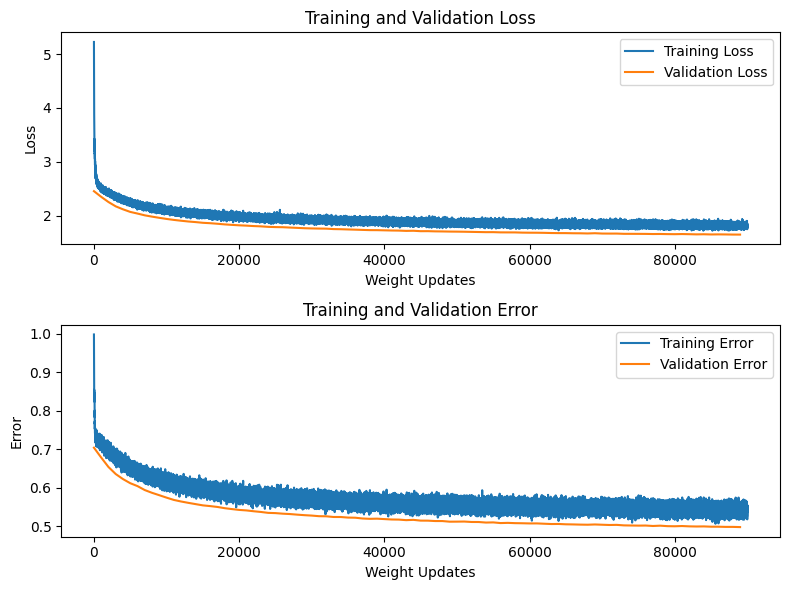

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(train_losses, label="Training Loss")
ax1.plot(range(0, len(train_losses), 1000), val_losses, label="Validation Loss")
ax1.set_xlabel("Weight Updates")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_title("Training and Validation Loss")

ax2.plot(train_errors, label="Training Error")
ax2.plot(range(0, len(train_errors), 1000), val_errors, label="Validation Error")
ax2.set_xlabel("Weight Updates")
ax2.set_ylabel("Error")
ax2.legend()
ax2.set_title("Training and Validation Error")

plt.tight_layout()
plt.show()

In [35]:
def generate_text(model, start_sequence, generate_length=1024):
    model.eval()
    generated_text = start_sequence
    input_sequence = torch.tensor([char_to_int[char] for char in start_sequence], dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(generate_length):
        mask = model._generate_square_subsequent_mask(input_sequence.size(1)).to(device)
        output = model(input_sequence, mask=mask)
        next_char_logits = output[0, -1, :]
        next_char_probs = F.softmax(next_char_logits, dim=0)
        next_char_index = torch.multinomial(next_char_probs, num_samples=1).item()
        next_char = int_to_char[next_char_index]
        generated_text += next_char
        next_input = torch.tensor([[next_char_index]], dtype=torch.long).to(device)
        input_sequence = torch.cat([input_sequence, next_input], dim=1)
    return generated_text



for i in range(4):
    print(f"GENERATED SENTENCE NUMBER {i+1}:")
    start_text = "To be, or not to"
    generated_text = generate_text(model, start_text)
    print(generated_text)
    print("\n")

GENERATED SENTENCE NUMBER 1:
To be, or not to ridinkess!
It my am said and your hoirs and you commpan you say to to his virialle
Demant be upon follow, did my st the freave asthy I fay haleearereakecke fisise meake se to’e teame in t he t ote move noustus stee owime brouth t ethe irspphote pouthinothor malerchootist wan, fee sthe suncelusthe e Tart ngsthath yostche te sst Ge te chale avesthist hathe Prnerthee wete h de tche nourrerenom mere oundd the howe tirearrcharthoid.
aie geacheve che thole’drme ame thastule lllve he llllle m.
Anapperathe wey asssavealiea, sanwadallit, y heaphaminy old;
s mus afe. sugowonois welllllkiferust blllisthave hoabud t m y.
Me y At tead’e finoounorck he we owisthiso mo canidivene spow rth, Tpparugre thadwa ddid oushithino th,
perissppppppoous kerer o. ge n merave hare ar ale sispporeare wie leathe mouile abe fastureareeellape rim n I ke llis ne he semoopppooulllpparmpptuste meapare stire inarm foritonqulined healotheathorinestousppe llinate onsinsthare, y